# Testing PA tagged rel04
This notebook is meant to be a demo for creating a rel04 pitch angle tagged product

Features
1. Splitting up counts within the field of view by the response function (DONE)
1. Compute PA for all the points in the split
1. Pixel corrections based on PA distribution matching between pixels
1. energy channel interpolation


## Splitting up counts within the field of view by the response function (DONE)


In [1]:
import ctypes
import ctypes.util
import os
from optparse import OptionParser
import time
import re

import matplotlib.pyplot as plt
import numpy as np
import spacepy.toolbox as tb
import spacepy.datamodel as dm
import spacepy.pycdf as pycdf
import spacepy.plot as spp

%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 25 days


This unreleased version of SpacePy is not supported by the SpacePy team.


In [2]:
sc_uvw_rot = np.matrix([[ 0.81915204, -0.57357644,  0.        ],
                            [ 0.57357644,  0.81915204,  0.        ],
                            [-0.        ,  0.        ,  1.        ]])

In [3]:
np.asarray((np.array([0,0,1])*sc_uvw_rot))[0]

array([ 0.,  0.,  1.])

In [4]:
    # 80 degree rotation around z
    hope3_rot = np.matrix([[ 0.98480775,  0.17364818,  0.        ],
                           [-0.17364818,  0.98480775,  0.        ],
                           [ 0.        ,  0.        ,  1.        ]]).transpose()

In [5]:
print(np.rad2deg(np.arccos(hope3_rot[1,1])))
print(np.rad2deg(np.arcsin(hope3_rot[0,0])))


10.0000009939
79.9999990061


In [6]:
np.cos(np.deg2rad(80)), np.sin(np.deg2rad(80))

(0.17364817766693041, 0.98480775301220802)

In [7]:
deg_polar_1 = np.matrix([[ np.cos(np.deg2rad(1)),  np.sin(np.deg2rad(1)),  0.        ],
                           [-np.sin(np.deg2rad(1)),  np.cos(np.deg2rad(1)),  0.        ],
                           [ 0.        ,  0.        ,  1.        ]]).transpose()

In [8]:
newrot = hope3_rot * deg_polar_1
print(newrot)

[[ 0.98162718 -0.190809    0.        ]
 [ 0.190809    0.98162718  0.        ]
 [ 0.          0.          1.        ]]


In [9]:
print(np.rad2deg(np.arccos(newrot[1,1])))
print(np.rad2deg(np.arcsin(newrot[0,0])))

11.0000009166
78.9999990834


In [10]:
np.cos(np.deg2rad(79)), np.sin(np.deg2rad(79))

(0.19080899537654492, 0.98162718344766398)

In [11]:
np.sqrt(3)*np.sqrt(2), np.sqrt(3*2)

(2.4494897427831783, 2.4494897427831779)

In [12]:
def get_g_peak(fwhm, mu):
    return 2*np.sqrt(np.log(2))/(np.sqrt(np.pi)*fwhm) # use this if you want a true gaussian
def g_eq(fwhm, mu, x):
    if len(np.asarray(x)) == 1:
        return mu
    t1 = get_g_peak(fwhm, mu)
#     t1=1
    exp1 = -4*np.log(2)*(x-mu)**2 
    exp2 = fwhm**2
    return t1*np.exp(exp1/exp2)


In [13]:
x = np.linspace(-8, 8, 100)
fwhm = 4.46
mu = -0.86
# curve = np.asarray([g_eq(fwhm, mu, v) for v in x])
curve = g_eq(fwhm, mu, x)
x.shape, curve.shape
peak = get_g_peak(fwhm, mu)

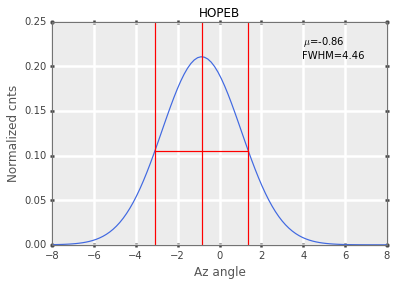

In [14]:
plt.plot(x, curve)
plt.axvline(mu, c='r')
plt.plot([mu-fwhm/2, mu+fwhm/2], [peak/2, peak/2], c='r')
plt.axvline(mu-fwhm/2, c='r')
plt.axvline(mu+fwhm/2, c='r')
plt.xlabel('Az angle')
plt.ylabel('Normalized cnts')
plt.title('HOPEB')
plt.text(4, peak, '$\mu$={0}\nFWHM={1}'.format(mu, fwhm))

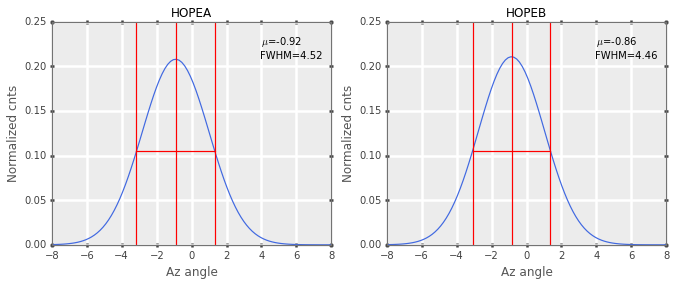

In [15]:
afwhm = 4.52
amu = -0.92
acurve = g_eq(afwhm, amu, x)
bfwhm = 4.46
bmu = -0.86
bcurve = g_eq(bfwhm, bmu, x)

fig=plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(x, acurve)
plt.axvline(amu, c='r')
plt.plot([amu-afwhm/2, amu+afwhm/2],  [peak/2, peak/2], c='r')
plt.axvline(amu-afwhm/2, c='r')
plt.axvline(amu+afwhm/2, c='r')
plt.xlabel('Az angle')
plt.ylabel('Normalized cnts')
plt.title('HOPEA')
plt.text(4, peak, '$\mu$={0}\nFWHM={1}'.format(amu, afwhm))
plt.subplot(122)
plt.plot(x, bcurve)
plt.axvline(bmu, c='r')
plt.plot([bmu-bfwhm/2, bmu+bfwhm/2],  [peak/2, peak/2], c='r')
plt.axvline(bmu-bfwhm/2, c='r')
plt.axvline(bmu+bfwhm/2, c='r')
plt.xlabel('Az angle')
plt.ylabel('Normalized cnts')
plt.title('HOPEB')
plt.text(4, peak, '$\mu$={0}\nFWHM={1}'.format(bmu, bfwhm))






In [16]:
# digitize the data and look for lines
dat = [
-80.19845,68.50645,
-77.915405,71.2337,
-77.44949,74.23647,
-76.53008,76.96558,
-75.61376,78.87559,
-75.6086,80.24077,
-75.59413,84.06326,
-75.13339,85.70086,
-74.669556,88.157555,
-71.48569,88.69928,
-71.48258,89.51839,
-67.41753,82.68692,
-66.06836,78.86256,
-64.26465,75.03758,
-63.360725,73.671165,
-43.362896,73.097786,
-42.445545,75.28083,
-41.528194,77.463875,
-40.608776,80.192986,
-39.236885,82.37541,
-37.404247,86.19542,
-36.94557,87.28694,
-35.571613,90.015434,
-34.216248,87.82929,
-31.063372,80.179955,
-9.278361,71.41303,
-8.366176,72.2309,
-4.2432632,80.689415,
-4.237065,82.32763,
-3.7773566,83.692184,
-1.9509196,85.873985,
-1.0377012,86.96488,
0.7928678,90.23883,
0.33729166,89.966415,
5.753586,79.85666,
5.740156,76.3072,
9.812449,71.38697,
27.995207,71.635185,
30.28032,74.90851,
32.57473,80.63915,
32.587124,83.91557,
33.50241,85.55255,
38.947628,83.08778,
37.14495,87.1858,
41.217247,82.26557,
44.362892,72.70499,
45.267845,71.61161,
62.55081,74.31838,
65.291504,77.86412,
66.21402,81.41234,
68.96297,87.14236,
72.157166,90.41444,
74.41335,86.04277,
75.76045,81.67234,
77.114784,79.213165,
81.62613,70.196785,]
dat = np.asarray(dat).reshape((-1,2))
ind = np.argsort(dat[:,0])
dat = dat[ind]

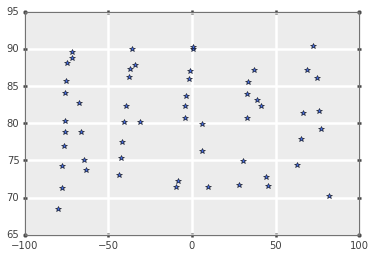

In [17]:
plt.plot(dat[:,0], dat[:,1], '*')

In [18]:
run, rise = dat[8]-dat[0]
rise, run, rise/run

(19.651105000000001, 5.528893999999994, 3.5542560591684382)

In [19]:
np.sqrt(5.5**2 + 20**2)

20.742468512691541

10.0


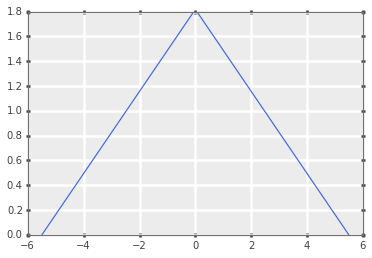

In [20]:
from scipy.integrate import trapz
def dist_tri(counts, deg, width=5.5, height=19.65):
    if (np.min(deg) < -width) or (np.min(deg) > width):
        raise(ValueError())
    area = 0.5 * width*2 * height
    ind = deg < 0
    slope = (height-0)/width
    intercept = slope*width
    y = slope*deg[ind] + intercept
    y = np.append(y, -slope*deg[~ind] + intercept)
    # now we have to scale this until the intergral is counts
    integral = trapz(y, deg)
    # get the scale
    y /= integral
    y *= counts
    return y
    

x = np.linspace(-5.5, 5.5, 100)
y = dist_tri(10, x) 
plt.plot(x, y)
print(trapz(y, x))    

9.99685731685


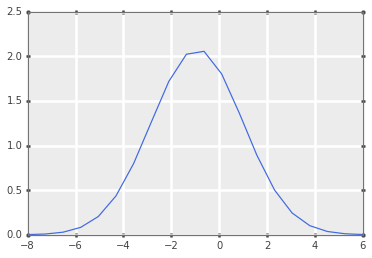

In [21]:
def get_g_peak(fwhm, mu):
    return 2*np.sqrt(np.log(2))/(np.sqrt(np.pi)*fwhm) # use this if you want a true gaussian
def g_eq(fwhm, mu, x):
    t1 = get_g_peak(fwhm, mu)
    exp1 = -4*np.log(2)*(x-mu)**2 
    exp2 = fwhm**2
    return t1*np.exp(exp1/exp2)

def dist_gauss(counts, fwhm, mu, x):
    y = g_eq(fwhm, mu, x)
    return np.asarray(y * counts)
    
x = np.linspace(-8, 6, 20)
y = dist_gauss(10, 4.52, -0.92, x)
print(trapz(y, x))
plt.plot(x, y)

In [22]:
%debug


ERROR: No traceback has been produced, nothing to debug.


In [23]:
# can this be done in 2D?

counts = 100
az = np.linspace(-8, 6, 30)
polar = np.linspace(-5.5, 5.5, 20)
out = np.zeros((len(polar), len(az)), dtype=float)
print(out.shape)


(20, 30)


Sum: 357.73592302 should be: 100


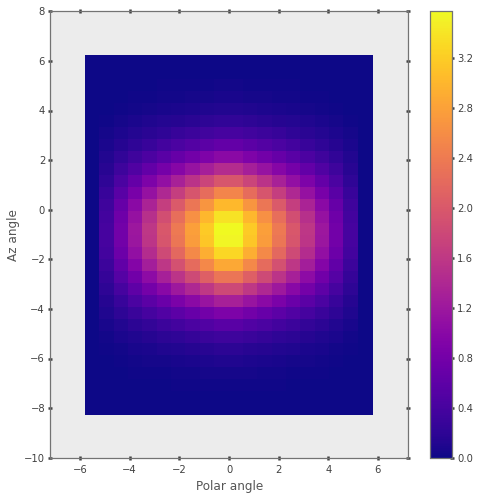

In [24]:
# start with polar split
polar_cnts1 = dist_tri(counts, polar)
# at each polar do the az split
for i, p in enumerate(polar_cnts1):
    az_tmp = dist_gauss(p, afwhm, amu, az)
    out[i] = az_tmp
plt.figure(figsize=(8,8))
plt.pcolormesh(tb.bin_center_to_edges(polar), tb.bin_center_to_edges(az), out.T)
plt.xlabel('Polar angle')
plt.ylabel('Az angle')
plt.axis('equal')

plt.colorbar()
print('Sum:', out.sum(), 'should be:', counts)



az_counts2.sum(): 207.110271222
Sum: 357.73592302


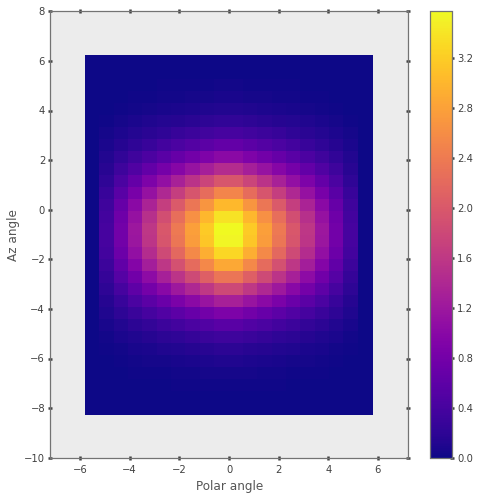

In [25]:
# start with az split
az_counts2 = dist_gauss(counts, afwhm, amu, az)
print('az_counts2.sum():', az_counts2.sum())

# at each polar do the az split
for i, a in enumerate(az_counts2):
    polar_tmp = dist_tri(a, polar)
    out[:,i] = polar_tmp
plt.figure(figsize=(8,8))
plt.pcolormesh(tb.bin_center_to_edges(polar), tb.bin_center_to_edges(az), out.T)
plt.xlabel('Polar angle')
plt.ylabel('Az angle')
plt.axis('equal')

plt.colorbar()
print('Sum:', out.sum())



### Try making sums concerve counts not integrals!


10.0


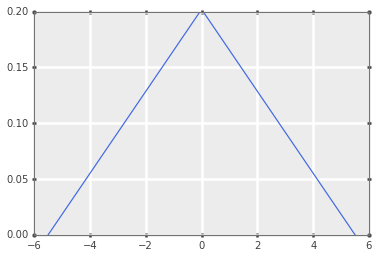

In [26]:
def dist_tri(counts, deg, width=5.5, height=19.65):
    if (np.min(deg) < -width) or (np.min(deg) > width):
        raise(ValueError())
    area = 0.5 * width*2 * height
    ind = deg <= 0
    slope = (height-0)/width
    intercept = slope*width
    y = slope*deg[ind] + intercept
    y = np.append(y, -slope*deg[~ind] + intercept)
    # now we have to scale this until the intergral is counts
    integral = y.sum()
    # get the scale
    y /= integral
    y *= counts
    return y
    

x = np.linspace(-5.5, 5.5, 100)
y = dist_tri(10, x) 
plt.plot(x, y)
print(y.sum())

10.0


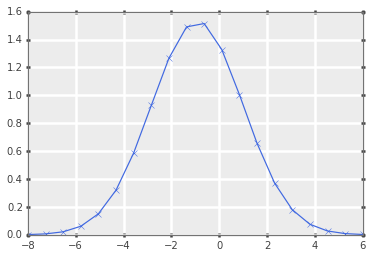

In [27]:
def get_g_peak(fwhm, mu):
    return 2*np.sqrt(np.log(2))/(np.sqrt(np.pi)*fwhm) # use this if you want a true gaussian
def g_eq(fwhm, mu, x):
    t1 = get_g_peak(fwhm, mu)
    exp1 = -4*np.log(2)*(x-mu)**2 
    exp2 = fwhm**2
    return t1*np.exp(exp1/exp2)

def dist_gauss(counts, fwhm, mu, x):
    y = g_eq(fwhm, mu, x)
    y /= y.sum()
    y *= counts    
    return y

x = np.linspace(-8, 6, 20)
y = dist_gauss(10, 4.52, -0.92, x)
print(y.sum())
plt.plot(x, y, 'x-')

In [28]:
# can this be done in 2D?

counts = 100
az = np.linspace(-8, 6, 30)
polar = np.linspace(-5.5, 5.5, 20)
out1 = np.zeros((len(polar), len(az)), dtype=float)
out2 = np.zeros((len(polar), len(az)), dtype=float)
print(out.shape)


(20, 30)


polar_cnts1.sum(): 100.0
Sum: 357.73592302 should be: 100


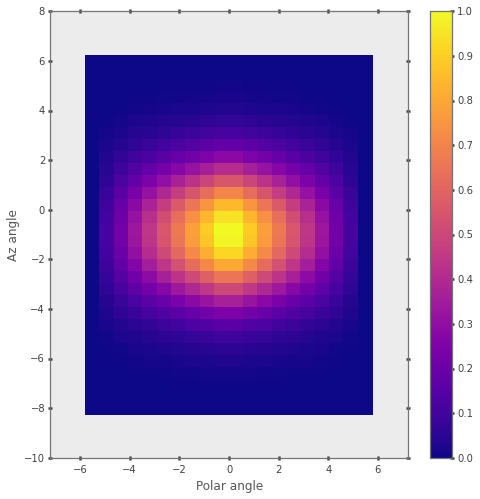

In [29]:
# start with polar split
polar_cnts1 = dist_tri(counts, polar)
print('polar_cnts1.sum():', polar_cnts1.sum())

# at each polar do the az split
for i, p in enumerate(polar_cnts1):
    az_tmp = dist_gauss(p, afwhm, amu, az)
    out1[i] = az_tmp
plt.figure(figsize=(8,8))
plt.pcolormesh(tb.bin_center_to_edges(polar), tb.bin_center_to_edges(az), out1.T)
plt.xlabel('Polar angle')
plt.ylabel('Az angle')
plt.axis('equal')

plt.colorbar()
print('Sum:', out.sum(), 'should be:', counts)



az_counts2.sum(): 100.0
Sum: 357.73592302


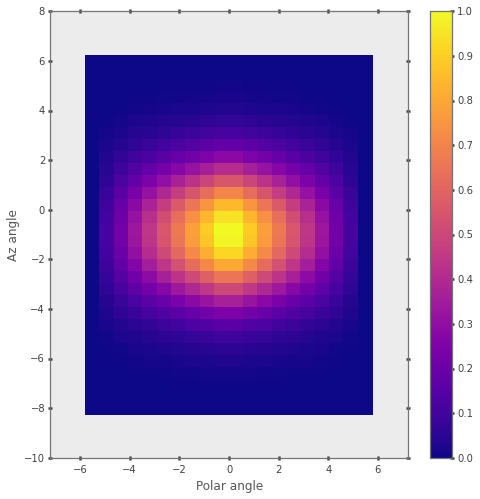

In [30]:
# start with az split
az_counts2 = dist_gauss(counts, afwhm, amu, az)
print('az_counts2.sum():', az_counts2.sum())

# at each polar do the az split
for i, a in enumerate(az_counts2):
    polar_tmp = dist_tri(a, polar)
    out2[:,i] = polar_tmp
plt.figure(figsize=(8,8))
plt.pcolormesh(tb.bin_center_to_edges(polar), tb.bin_center_to_edges(az), out2.T)
plt.xlabel('Polar angle')
plt.ylabel('Az angle')
plt.axis('equal')

plt.colorbar()
print('Sum:', out.sum())



(array([  14.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,   20.,    0.,    0.,    0.,    0.,    0.,
          13.,    0.,    0.,   13.,    0.,    8.,   34.,  453.,   15.,
           0.,    9.,    0.,    0.,    9.,    0.,    0.,    0.,    0.,
           0.,    6.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    6.]),
 array([ -1.11022302e-16,  -1.06581410e-16,  -1.02140518e-16,
         -9.76996262e-17,  -9.32587341e-17,  -8.88178420e-17,
         -8.43769499e-17,  -7.99360578e-17,  -7.54951657e-17,
         -7.10542736e-17,  -6.66133815e-17,  -6.21724894e-17,
         -5.77315973e-17,  -5.32907052e-17,  -4.88498131e-17,
         -4.44089210e-17,  -3.99680289e-17,  -3.55271368e-17,
         -3.10862447e-17,  -2.66453526e-17,  -2.22044605e-17,
         -1.77635684e-17,  -1.33226763e-17,  -8.88178420e-18,
         -4.44089210e-18,   0.00000000e+00,   4.44089210e-18,
          8.88178420e-18,   1.33226763e-17

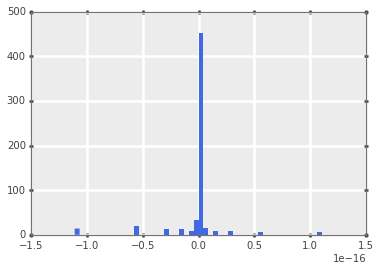

In [31]:
plt.hist((out1 - out2).flatten(), 50)

<class 'numpy.ndarray'> float64
[  6.39488462e-14  -1.10000000e+02   1.00000000e+02]
<class 'numpy.ndarray'> float64
[  2.27373675e-13  -1.10000000e+04   1.00000000e+02]


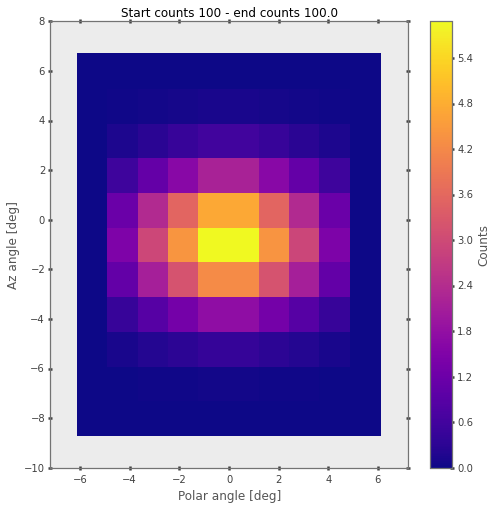

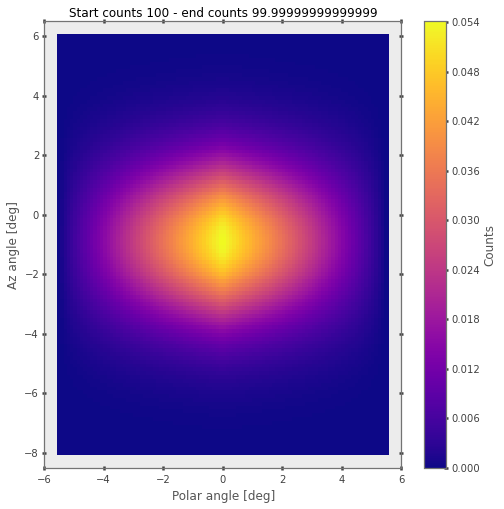

In [32]:
def split_fov(counts, pixel, sc, n_polar=10, n_azi=11, plot=False):
    # start with az split
    assert sc.upper() in ('A', 'B')
    assert pixel in (1,2,3,4,5)
    assert n_polar > 0
    assert n_azi > 0
    out2 = np.zeros((n_polar, n_azi), dtype=float)
    
    if n_azi == 1:
        az = np.asarray(0.0)
    else:
        az = np.linspace(-8, 6, n_azi)
    if n_polar == 1:
        polar = np.asarray(0.0)
    else:
        polar = np.linspace(-5.5, 5.5, n_polar)
    
    if sc == 'A':
        fwhm = 4.52
        mu = -0.92
    else:
        fwhm = 4.46
        mu = -0.86
        
    curve = g_eq(afwhm, amu, x)
    az_counts2 = dist_gauss(counts, fwhm, mu, az)
    np.testing.assert_almost_equal(counts, az_counts2.sum(), decimal=5) 
    
    # at each polar do the az split
    try:
        for i, a in enumerate(az_counts2):
            polar_tmp = dist_tri(a, polar)
            out2[:,i] = polar_tmp
    except TypeError: # 0-d array
        out2[:,0] = dist_tri(az_counts2, polar)
    assert (out2 >=0).all()
        
    if plot:
        plt.figure(figsize=(8,8))
        try:
            if (len(az) > 1) and (len(polar) > 1):
                plt.pcolormesh(tb.bin_center_to_edges(polar), tb.bin_center_to_edges(az), out2.T)
            elif len(polar) > 1:
                plt.scatter(polar, az.repeat(len(polar)), s=50, c = out2.flat)
                print('polar', polar.shape, 'az.repeat(len(polar))', az.repeat(len(polar)).shape, 'out2', out2.shape)
            elif len(az) > 1:
                plt.scatter(polar.repeat(len(az)), az, s=50, c = out2.flat)
                print('polar', polar.shape, 'az.repeat(len(polar))', az.repeat(len(polar)).shape, 'out2', out2.shape)
        except TypeError:
            try:
                plt.scatter(polar, az.repeat(len(polar)), s=50, c = out2.flat)
                print('polar', polar.shape, 'az.repeat(len(polar))', az.repeat(len(polar)).shape, 'out2', out2.shape)
            except TypeError:
                plt.scatter(polar.repeat(len(az)), az, s=50, c = out2.flat)
                print('polar.repeat(len(az))', polar.repeat(len(az)).shape, 'az', az.shape, 'out2', out2.shape)
            
        plt.xlabel('Polar angle [deg]')
        plt.ylabel('Az angle [deg]')
        plt.axis('equal')
        plt.title('Start counts {0} - end counts {1}'.format(counts, out2.sum()))

        cb = plt.colorbar()
        cb.set_label('Counts')
    np.testing.assert_almost_equal(counts, out2.sum(), decimal=5) 
    # build up a list of tuples of the angle offset and the counts (polar, azi, counts)
    try:
        ans = np.asarray([(polar[index[0]], az[index[1]], x) for index, x in np.ndenumerate(out2)])
        ind = np.argsort(ans[:,0], kind='mergesort')
    except IndexError:
        try:
            ans = np.asarray([(polar[index[0]], az, x) for index, x in np.ndenumerate(out2)])
            ind = np.argsort(ans[:,0], kind='mergesort')     
        except IndexError:
            ans = np.asarray([(polar, az[index[1]], x) for index, x in np.ndenumerate(out2)])
            ind = np.argsort(ans[:,0], kind='mergesort')     

    return ans[ind]
    
              
c1 = split_fov(100, 1, 'a', plot=True)
print(type(c1), c1.dtype)
print(c1.sum(axis=0))
c2 = split_fov(100, 1, 'a', plot=True,  n_polar=100, n_azi=110)
print(type(c2), c2.dtype)
print(c2.sum(axis=0)[:10])


Overall the split within the FOV is complete and is very possible. 

It does not matter if the split is done in azi then polar or polar then azi the same counts are given.

The above function provides the capability to split up the FOV into angles delta in azi and polar

## Compute PA for all the points in the split


In [33]:
from make_HOPE_PA_tags_rel04 import EventTimer, smart_tt2000_to_epoch, makeFullTimes_Ele, makeFullTimes_Ion
from make_HOPE_PA_tags_rel04 import interpolateB, extract_date_string, L1arg, Barg




In [34]:
args = ['~/Downloads/rbspa_ect-hope-sci-L1_20150101_v2.1.0.cdf', 
        '~/Downloads/rbsp-a_magnetometer_uvw_emfisis-L2_20150101_v1.6.1.cdf',
        'rbspa_rel04_ect-hope-PAtags-L3_20150101_v1.0.0.cdf']
outfile = args[-1]
date_string = extract_date_string(outfile)
L1infile, sc1 = L1arg(args[:-1])
Binfile, scB = Barg(args[:-1], date_string)
assert (np.asarray([sc1, scB]) == sc1).all()

libname = os.path.join('/Users/blarsen/git/hope/pitch_angle', 'lib_hope_angles_' + os.environ['HWSWID']) + '.so'
lib = ctypes.CDLL(os.path.abspath(libname))

print(L1infile, Binfile, outfile, libname)
for f in (L1infile, Binfile, outfile, libname):
    print(os.path.isfile(os.path.expanduser(f)))
    
if os.path.isfile(outfile):
    os.remove(outfile)

~/Downloads/rbspa_ect-hope-sci-L1_20150101_v2.1.0.cdf ~/Downloads/rbsp-a_magnetometer_uvw_emfisis-L2_20150101_v1.6.1.cdf rbspa_rel04_ect-hope-PAtags-L3_20150101_v1.0.0.cdf /Users/blarsen/git/hope/pitch_angle/lib_hope_angles_OSX.so
True
True
False
True


1. Read in all the infiles
1. Compute the time of each measurement 
1. Interpolate the magnetometer to each of of the measurement times

In [35]:
Time1 = time.time()
# Open the CDF files
L1cdf = pycdf.CDF(L1infile)
Bcdf = pycdf.CDF(Binfile)
Time1 = EventTimer('CDFs open', Time1)  # time

TaggedData = dm.SpaceData()
makeFullTimes_Ele(L1cdf, TaggedData)
Time1 = EventTimer('Full times computed electrons', Time1)  # time
makeFullTimes_Ion(L1cdf, TaggedData)
Time1 = EventTimer('Full times computed ions', Time1)  # time

magInterp_Ele, magInterp_Ion = interpolateB(TaggedData, Bcdf, lib)
Time1 = EventTimer('Magnetometer interpolated', Time1)  # time



0.63 CDFs open
0.74 Full times computed electrons
0.67 Full times computed ions
1.23 Magnetometer read from disk
0.45 Measurement fractions computed
0.83 Slerp finished
0.38 Measurement fractions computed
0.70 Slerp finished
3.62 Magnetometer interpolated


TaggedData
+
|____Epoch_Ele (spacepy.datamodel.dmarray (4143,))
|____Epoch_Ele_FRAME_subtime (numpy.ndarray (16, 72))
|____Epoch_Ion (spacepy.datamodel.dmarray (3469,))
|____Epoch_Ion_FRAME_subtime (numpy.ndarray (16, 72))
|____Full_times_Ele (numpy.ndarray (4143, 16, 72))
|____Full_times_Ion (numpy.ndarray (3469, 16, 72))


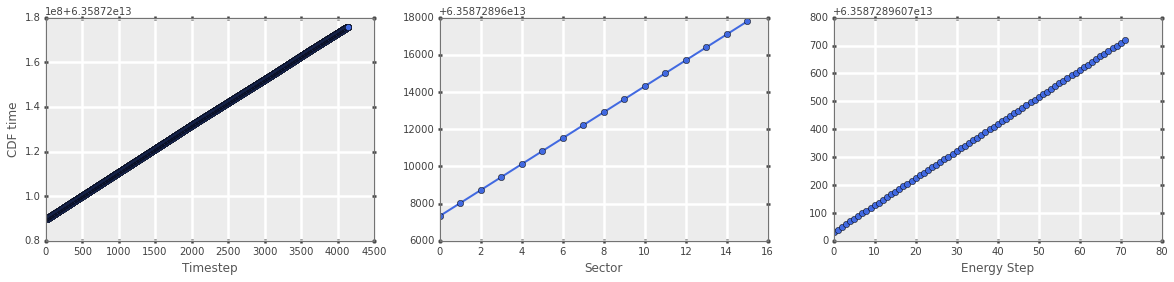

In [36]:
print('TaggedData')
TaggedData.tree(verbose=True)
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(131)
ax.plot(TaggedData['Full_times_Ele'][:,0,0], '-o', lw=2)
plt.xlabel('Timestep')
plt.ylabel('CDF time')

ax = fig.add_subplot(132)
ax.plot(TaggedData['Full_times_Ele'][0,:,0], '-o', lw=2)
plt.xlabel('Sector')

ax = fig.add_subplot(133)
ax.plot(TaggedData['Full_times_Ele'][0,0,:], '-o', lw=2)
plt.xlabel('Energy Step')


In [37]:
hope1_rot = np.matrix([[0.30432233, 0.17364818, 0.93660783],
                       [-0.05366024, 0.98480775, -0.16514923],
                       [-0.95105652, 0., 0.30901699]]).transpose()
hope2_rot = np.matrix([[0.79672621, 0.17364818, 0.57885547],
                       [-0.14048433, 0.98480775, -0.10206784],
                       [-0.58778525, 0., 0.80901699]]).transpose()
# 80 degree rotation around z
hope3_rot = np.matrix([[0.98480775, 0.17364818, 0.],
                       [-0.17364818, 0.98480775, 0.],
                       [0., 0., 1.]]).transpose()
hope4_rot = np.matrix([[0.79672621, 0.17364818, -0.57885547],
                       [-0.14048433, 0.98480775, 0.10206784],
                       [0.58778525, 0., 0.80901699]]).transpose()
hope5_rot = np.matrix([[0.30432233, 0.17364818, -0.93660783],
                       [-0.05366024, 0.98480775, 0.16514923],
                       [0.95105652, 0., 0.30901699]]).transpose()

rots = (hope1_rot, hope2_rot, hope3_rot, hope4_rot, hope5_rot)

# spin axis is omega
# compute omega in uvw
sc_uvw_rot = np.matrix([[0.81915204, -0.57357644, 0.],
                        [0.57357644, 0.81915204, 0.],
                        [-0., 0., 1.]])
# omega is along Z in xyz and uvw!!  But leave this in for tuning
omega_uvw = np.asarray((np.array([0, 0, 1]) * sc_uvw_rot))[0]

In [38]:
# long
# computePAarb(double rots[3][3],
# double magInterp[3],
# double offset[][2],
# double PA[],
# double PHI[],
# double omega[3],
# long n_values) {

lib.computePAarb.argtypes = (np.ctypeslib.ndpointer(dtype=ctypes.c_double, ndim=2, shape=(3,3), flags='C'),  # rot
                             np.ctypeslib.ndpointer(dtype=ctypes.c_double, ndim=1, shape=(3,), flags='C'),  # magInterp
                             np.ctypeslib.ndpointer(dtype=ctypes.c_double, ndim=2, flags='C'),  # offset
                             np.ctypeslib.ndpointer(dtype=ctypes.c_double, ndim=1, flags='C'),  # PA
                             np.ctypeslib.ndpointer(dtype=ctypes.c_double, ndim=1, flags='C'),  # PHI
                             np.ctypeslib.ndpointer(dtype=ctypes.c_double, ndim=1, shape=(3,), flags='C'),  # omega
                             ctypes.c_long,   # n_values
                            )

lib.computePAarb.restype = ctypes.c_long # number of calculations

In [39]:

# PA[][N_PIXELS][N_SECTORS][N_ENERGIES],
N_TIMES = L1cdf['Elc_Cntr_e'].shape[0]
N_PIXELS = 5
N_SECTORS = 16
N_ENERGIES = 72




Choose 1 time, 1 pixel, 1 sector, 1 energy and split up coutns and do PA,PHA calculation

(110, 3)
-8.0 6.0
magInterp_in (3,)
offset_in (110, 2)
PA (110,) PHI (110,)
omega_uvw_in (3,)


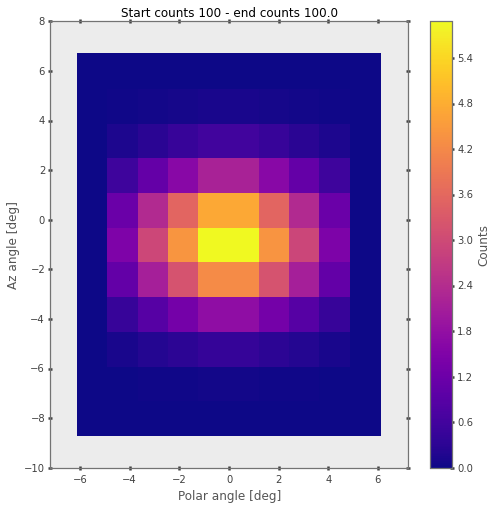

In [40]:
t_ind = 100 # make sure not a BS mode for testing
pixel = 3
sector = 1
energy = 32

n_polar=10
n_azi=11

# def split_fov(counts, pixel, sc, n_polar=10, n_azi=11, plot=False):

fov_split = split_fov(100, pixel, 'a', plot=True,  n_polar=n_polar, n_azi=n_azi)

print(fov_split.shape)
print(fov_split.min(), fov_split.max())



rot_in = np.require(rots[pixel-1],
                   dtype=ctypes.c_double,
                    requirements='C')


magInterp_in = np.require(magInterp_Ele[t_ind, sector, energy], dtype=ctypes.c_double, requirements='C')
print('magInterp_in', magInterp_in.shape)

offset_in = np.require(fov_split[:, 0:2], dtype=ctypes.c_double, requirements='C')
print('offset_in', offset_in.shape)

PA = np.empty(np.product((n_polar, n_azi)), dtype=ctypes.c_double, order='C')
PA[...] = -999
PHI = np.empty(np.product((n_polar, n_azi)), dtype=ctypes.c_double, order='C')
PHI[...] = -999

print('PA', PA.shape, 'PHI', PHI.shape)

omega_uvw_in = np.require(omega_uvw, dtype=ctypes.c_double, requirements='C')

print('omega_uvw_in', omega_uvw_in.shape)


    
# rotnp = np.require(np.dstack([np.asarray(rots[pixel]).T] * np.product(shape)).T,
#                    dtype=ctypes.c_double,
#                    requirements='C')

# mag_tmp = np.require(magInterp_Ele[:, sector, energy].reshape(-1, 3),
#                      dtype=ctypes.c_double,
#                      requirements='C')


110 110


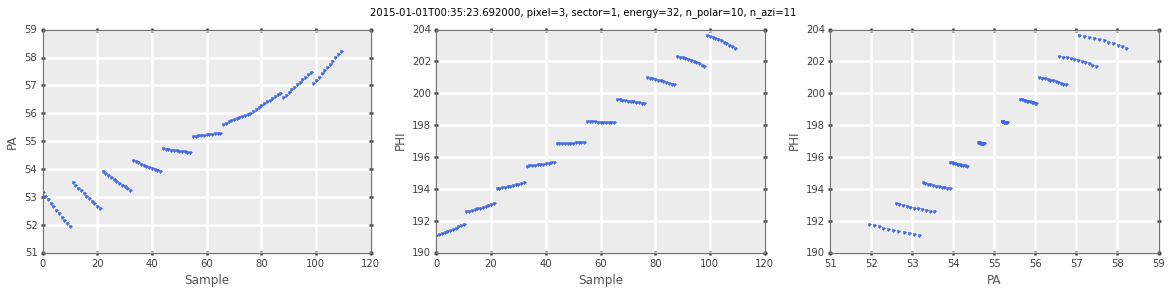

In [41]:
# long
# computePAarb(double rots[3][3],
# double magInterp[3],
# double offset[][2],
# double PA[],
# double PHI[],
# double omega[3],
# long n_values) {

n_calc = lib.computePAarb(rot_in, magInterp_in, offset_in, PA, PHI, omega_uvw_in, len(PA))
print(n_calc, len(PA))


fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.plot(PA, '.')
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.plot(PHI, '.')
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
ax3.plot(PA, PHI, '.')
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

# t_ind = 100 # make sure not a BS mode for testing
# pixel = 3
# sector = 1
# energy = 32

# n_polar=10
# n_azi=11

tm = pycdf.lib.epoch_to_datetime(TaggedData['Epoch_Ele'][t_ind])

fig.suptitle('{0}, pixel={1}, sector={2}, energy={3}, n_polar={4}, n_azi={5}'.format(tm.isoformat(), 
                                                                                     pixel, sector, energy, 
                                                                                    n_polar, n_azi))





<class 'numpy.ndarray'> <class 'numpy.ndarray'>


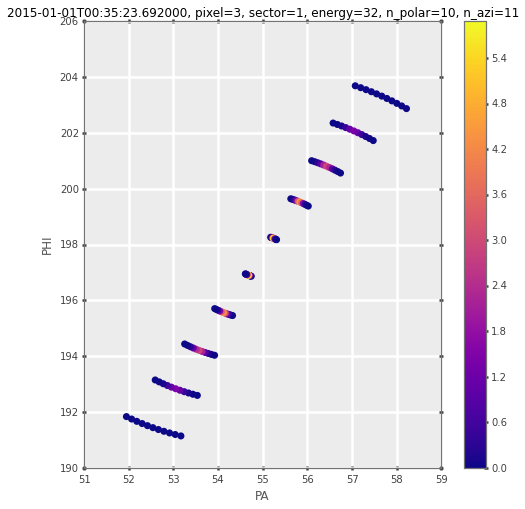

In [42]:
# plot the counts as the color of each point

plt.figure(figsize=(8,8))
print(type(PA), type(PHI))



plt.scatter(PA, PHI, c=fov_split[:,2], s=50)
plt.xlabel('PA')
plt.ylabel('PHI')
plt.title('{0}, pixel={1}, sector={2}, energy={3}, n_polar={4}, n_azi={5}'.format(tm.isoformat(), 
                                                                                     pixel, sector, energy, 
                                                                                    n_polar, n_azi))
plt.colorbar()

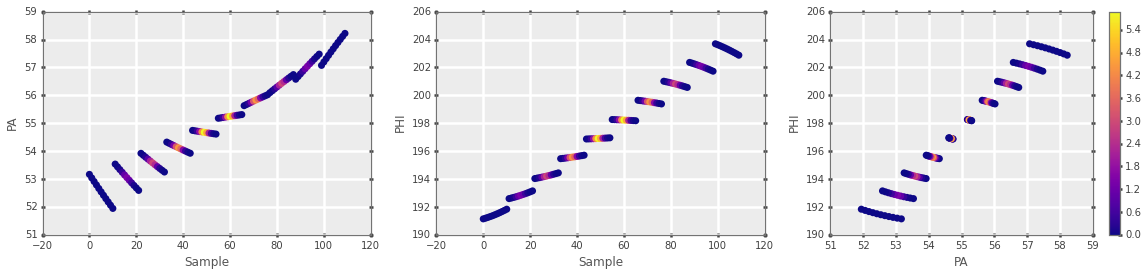

In [43]:

fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(131)
ax1.scatter(np.arange(len(PA)), PA, c=fov_split[:,2], s=50)
ax1.set_xlabel('Sample')
ax1.set_ylabel('PA')

ax2 = fig.add_subplot(132)
ax2.scatter(np.arange(len(PHI)), PHI, c=fov_split[:,2], s=50)
ax2.set_xlabel('Sample')
ax2.set_ylabel('PHI')

ax3 = fig.add_subplot(133)
sc = ax3.scatter(PA, PHI, c=fov_split[:,2], s=50)
ax3.set_xlabel('PA')
ax3.set_ylabel('PHI')

plt.colorbar(sc)

In [44]:
def split_full_counts(t_ind, pixel, sector, energy, sc='a', n_polar=10, n_azi=11, counts=100, plot=False):

    fov_split = split_fov(counts, pixel, sc, plot=plot,  n_polar=n_polar, n_azi=n_azi)

    print(fov_split.shape)
    print(fov_split.min(), fov_split.max())

    rot_in = np.require(rots[pixel-1],
                       dtype=ctypes.c_double,
                        requirements='C')


    magInterp_in = np.require(magInterp_Ele[t_ind, sector, energy], dtype=ctypes.c_double, requirements='C')
    print('magInterp_in', magInterp_in.shape)

    offset_in = np.require(fov_split[:, 0:2], dtype=ctypes.c_double, requirements='C')
    print('offset_in', offset_in.shape)

    PA = np.empty(np.product((n_polar, n_azi)), dtype=ctypes.c_double, order='C')
    PA[...] = -999
    PHI = np.empty(np.product((n_polar, n_azi)), dtype=ctypes.c_double, order='C')
    PHI[...] = -999

    print('PA', PA.shape, 'PHI', PHI.shape)

    omega_uvw_in = np.require(omega_uvw, dtype=ctypes.c_double, requirements='C')

    print('omega_uvw_in', omega_uvw_in.shape)
    n_calc = lib.computePAarb(rot_in, magInterp_in, offset_in, PA, PHI, omega_uvw_in, len(PA))


    if plot:
        fig = plt.figure(figsize=(20,4))
        ax1 = fig.add_subplot(131)
        ax1.scatter(np.arange(len(PA)), PA, c=fov_split[:,2], s=50)
        ax1.set_xlabel('Sample')
        ax1.set_ylabel('PA')

        ax2 = fig.add_subplot(132)
        ax2.scatter(np.arange(len(PHI)), PHI, c=fov_split[:,2], s=50)
        print('1111111', fov_split[:,2].shape)
        ax2.set_xlabel('Sample')
        ax2.set_ylabel('PHI')

        ax3 = fig.add_subplot(133)
        sc = ax3.scatter(PA, PHI, c=fov_split[:,2], s=50)
        ax3.set_xlabel('PA')
        ax3.set_ylabel('PHI')

        plt.colorbar(sc)



(2500, 3)
-8.0 6.0
magInterp_in (3,)
offset_in (2500, 2)
PA (2500,) PHI (2500,)
omega_uvw_in (3,)
1111111 (2500,)


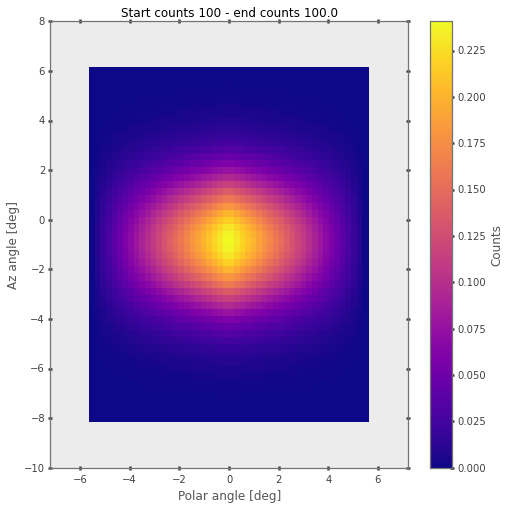

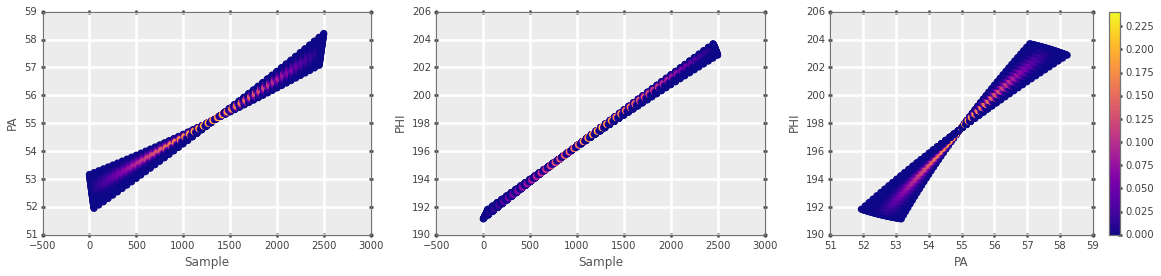

In [45]:
split_full_counts(100, 3, 1, 32, n_polar=50, n_azi=50, counts=100, plot=True)

#  so does this make sense?

polar (10,) az.repeat(len(polar)) (10,) out2 (10, 1)
(10, 3)
-5.5 20.0
magInterp_in (3,)
offset_in (10, 2)
PA (10,) PHI (10,)
omega_uvw_in (3,)
1111111 (10,)


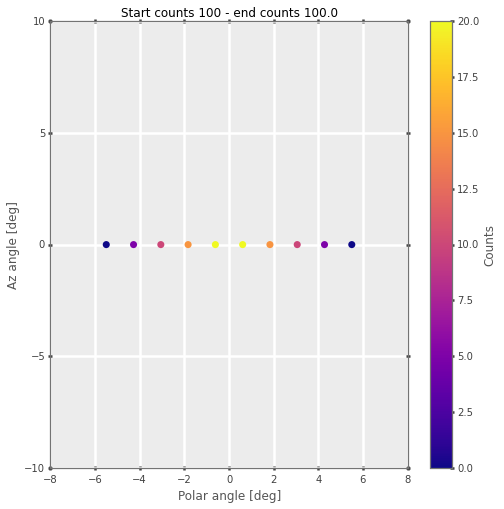

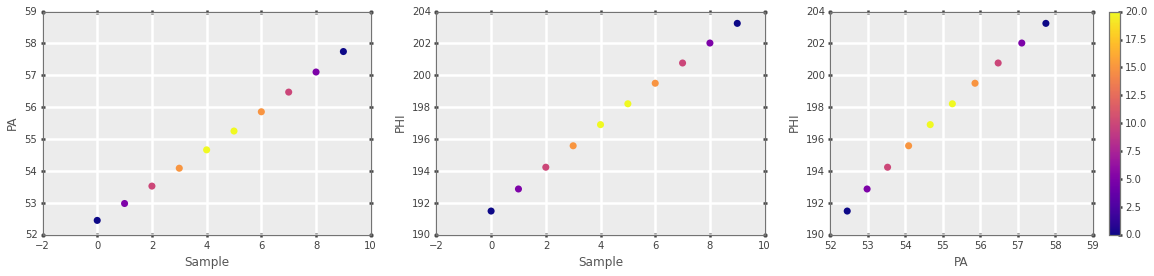

In [46]:
split_full_counts(100, 3, 1, 32, n_polar=10, n_azi=1, counts=100, plot=True)

In [47]:
%debug


ERROR: No traceback has been produced, nothing to debug.


polar.repeat(len(az)) (10,) az (10,) out2 (1, 10)
(10, 3)
-8.0 30.9604235797
magInterp_in (3,)
offset_in (10, 2)
PA (10,) PHI (10,)
omega_uvw_in (3,)
1111111 (10,)


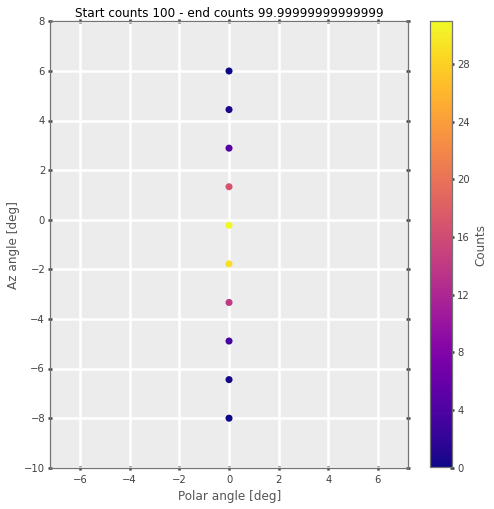

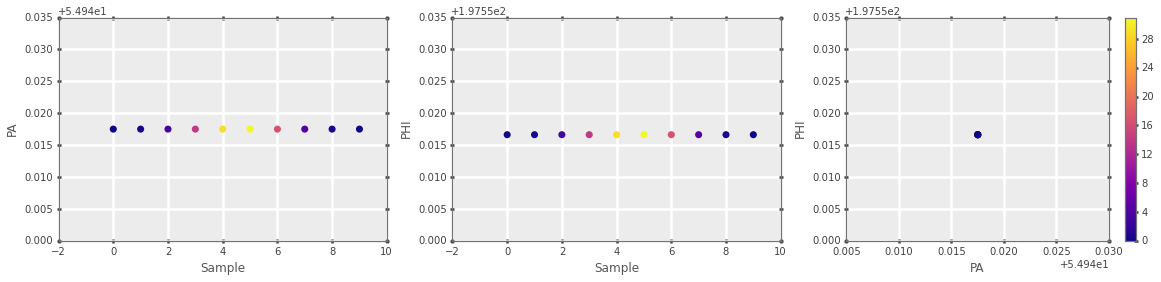

In [48]:
split_full_counts(100, 3, 1, 32, n_polar=1, n_azi=10, counts=100, plot=True)

In [49]:
%debug

ERROR: No traceback has been produced, nothing to debug.
